# ResNet

This notebook is designed for simple evaluations of the ResNet module used in this project.

A quick view of the [ImageNette Dataset](https://github.com/fastai/imagenette):
```
data/
└── imagenette2-160
    ├── train
    │   ├── n01440764
    │   ├── n02102040
    │   ├── n02979186
    │   ├── n03000684
    │   ├── n03028079
    │   ├── n03394916
    │   ├── n03417042
    │   ├── n03425413
    │   ├── n03445777
    │   └── n03888257
    └── val
        ├── n01440764
        ├── n02102040
        ├── n02979186
        ├── n03000684
        ├── n03028079
        ├── n03394916
        ├── n03417042
        ├── n03425413
        ├── n03445777
        └── n03888257
```


## Required Imports

In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms  # preprocessing
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.models import ResNet50_Weights
from tqdm.auto import tqdm

# Fix the import paths by adding the parent directory to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path

from models.utils import compute_accuracy, ResidualBlock, ResNet
from visualizations.loss_surface import visualize_loss_surface

import wandb

## Basic Forward Pass with the Pretrained Model

In [2]:
baseline = models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [3]:
# Calculate total number of parameters
total_params = sum(p.numel() for p in baseline.parameters())
print(f"Total number of parameters: {total_params:,}")  # print the number of model parameters

Total number of parameters: 25,557,032


In [4]:
# dummy input
x = torch.randn(16, 3, 224, 224)  # B X C X H X W, C = 3 for RGB images

In [5]:
output_baseline = baseline(x)

In [6]:
print(output_baseline.shape)

torch.Size([16, 1000])


As we can see, the output is a tensor of shape `(16, 1000)` for an input of batch size $16$, which represents the probabilities of each one of the images in the batch belonging to each of the $1,000$ classes in the [ImageNet dataset](https://www.image-net.org/download.php).

Now let's test for our custom implementation. Recall this chart for basic ResNet architectural variations:
![ResNet Architecture Variations](images/resnet_architectures.png)

So for ResNet-50, we set the number of residual blocks as: `[3, 4, 6, 3]`.

In [7]:
model = ResNet(ResidualBlock, [3, 4, 6, 3])

In [8]:
load_pretrained = True

In [9]:
# load checkpoint
if load_pretrained:
    checkpoint_path = "checkpoints/last.pt"
    model.load_state_dict(
        torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    print(f"Loaded checkpoint from {checkpoint_path}")

Loaded checkpoint from checkpoints/last.pt


In [10]:
# check the number of model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 25,557,032


In [11]:
output = model(x)

In [12]:
print(output.shape)

torch.Size([16, 1000])


## Dataset Preprocessing

In [13]:
# define transformations
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [14]:
# load ImageNette dataset
train_data = torchvision.datasets.ImageFolder(root='../data/imagenette2/train', transform=transform)
val_data = torchvision.datasets.ImageFolder(root='../data/imagenette2/val', transform=transform)

In [15]:
# define dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=0)

## Setup the Training

In [20]:
# define loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# move the network to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

num_epochs = 5
train = True

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

## Training the Network

In [22]:
# initialize wandb logger
wandb.init(project="laser",
           name="ResNet-50-test")

In [23]:
# training loop
if train:
    for epoch in range(num_epochs):
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
            for i, data in enumerate(pbar):
                inputs, labels = data

                # move to GPU if available
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                pbar.set_postfix({"loss": loss.item()})

                # log the loss to wandb
                wandb.log({"train_loss": loss.item()})

        # save checkpoint
        if epoch != num_epochs - 1:
            torch.save(model.state_dict(), f"checkpoints/resnet_epoch_{epoch + 1}.pt")
        else:
            torch.save(model.state_dict(), f"checkpoints/last.pt")
        print(f"Checkpoint for epoch {epoch + 1} saved.")

Epoch 1/5:   0%|          | 0/148 [00:00<?, ?it/s]

Checkpoint for epoch 1 saved.


Epoch 2/5:   0%|          | 0/148 [00:00<?, ?it/s]

Checkpoint for epoch 2 saved.


Epoch 3/5:   0%|          | 0/148 [00:00<?, ?it/s]

Checkpoint for epoch 3 saved.


Epoch 4/5:   0%|          | 0/148 [00:00<?, ?it/s]

Checkpoint for epoch 4 saved.


Epoch 5/5:   0%|          | 0/148 [00:00<?, ?it/s]

Checkpoint for epoch 5 saved.


# Loss Surface Visualization

The 3D loss surface plot helps us understand the geometry of the loss landscape around our model's current parameters. This visualization:

1. Takes two random directions in the parameter space
2. Creates a grid of points by perturbing the model parameters along these directions
3. Computes the loss at each point
4. Plots the resulting surface

Key insights from this visualization:
- Smooth vs rough surfaces indicate the stability of optimization
- Local minima and maxima become visible
- The shape around the current solution shows if we've reached a good optimization point

Computing loss landscape...
Progress: 50/225 points calculated (22.2%)
Progress: 100/225 points calculated (44.4%)
Progress: 150/225 points calculated (66.7%)
Progress: 200/225 points calculated (88.9%)
Progress: 225/225 points calculated (100.0%)
Creating 3D visualization...
Plot saved as resnet50_loss_surface.png


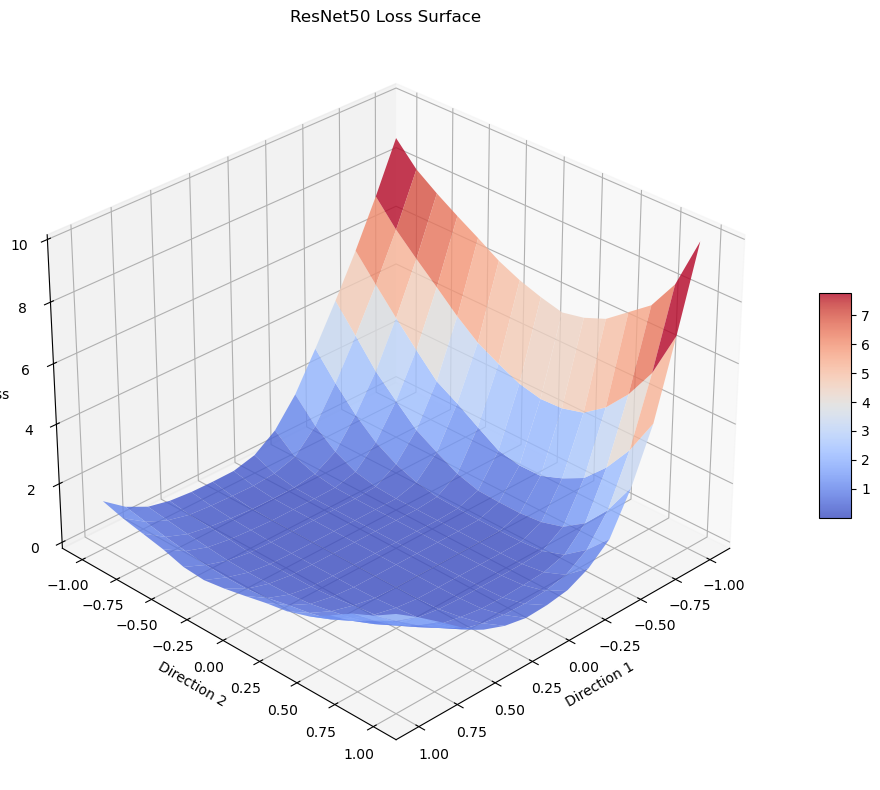

In [20]:
visualize_loss_surface(model, train_loader)

### Baseline Evaluation

In [21]:
baseline = baseline.cuda()

In [22]:
print(f"Accuracy of the network on the 10000 test images: {100 * compute_accuracy(baseline, val_loader)} %")

  0%|          | 0/62 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 0.9171974522292993 %


### Custom Implementation Evaluation

In [23]:
model = model.cuda()

In [24]:
print(f"Accuracy of the network on the 10000 test images: {100 * compute_accuracy(model, val_loader)} %")

  0%|          | 0/62 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 68.99363057324841 %
